<a href="https://colab.research.google.com/github/shuaicongbaobao/Colab-140/blob/main/Rain_Wu_RNN%2BEnsemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gc
import os
import random
import warnings
import numpy as np
import pandas as pd
from IPython.display import display

!pip install timm
import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR

from google.colab import drive
drive.mount('/content/drive')

from scipy import signal


warnings.filterwarnings('ignore', category=Warning)
gc.collect()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


3496

In [ ]:
import pandas as pd
train_pred_cnn=pd.read_csv("/content/drive/MyDrive/hms-harmful-brain-activity-classification/cnn_train (11).csv")
validation_cnn=pd.read_csv("/content/drive/MyDrive/hms-harmful-brain-activity-classification/cnn_validation (11).csv")
train_pred_cnn = train_pred_cnn.rename(columns={"Unnamed: 0": "id"})
validation_cnn = validation_cnn.rename(columns={"Unnamed: 0": "id"})
for i in range(6):
  validation_cnn=validation_cnn[(validation_cnn[f"y_{i}"]<10) & (validation_cnn[f"y_{i}"]>-10)]
train_pred_cnn.head()

,id,y_0,y_1,y_2,y_3,y_4,y_5
0,389995115,-1.331056,-1.130222,-1.118904,-1.262536,-1.192842,-0.955191
1,935185934,-1.431631,-1.098763,-1.226533,-1.299056,-1.382743,-1.080804
2,93013179,-1.372694,-1.253245,-1.310082,-1.397910,-1.157106,-1.057166
3,562194482,-1.500806,-1.102256,-1.128679,-1.331989,-1.199087,-0.945857
4,1030430135,-1.416428,-1.191240,-1.280547,-1.334359,-1.328857,-1.038767


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [ ]:
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values

y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [ ]:
%%time
READ_SPEC_FILES = False

# READ ALL SPECTROGRAMS
PATH = '/content/drive/MyDrive/hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if READ_SPEC_FILES:
    spectrograms = {}
    for i,f in enumerate(files):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[:,1:].values
else:
    spectrograms = np.load('/content/drive/MyDrive/brain-spectrograms/specs.npy',allow_pickle=True).item()
print('Train spectrograms read!')

There are 11166 spectrogram parquets
Train spectrograms read!
CPU times: user 756 ms, sys: 3.68 s, total: 4.43 s
Wall time: 40.4 s


In [ ]:
%%time
READ_EEG_SPEC_FILES = False

if READ_EEG_SPEC_FILES:
    all_eegs = {}
    for i,e in enumerate(train.eeg_id.values):
        if i%100==0: print(i,', ',end='')
        x = np.load(f'/content/drive/MyDrive/brain-spectrograms/EEG_Spectrograms/{e}.npy')
        all_eegs[e] = x
else:
    all_eegs = np.load('/content/drive/MyDrive/archive/eeg_specs.npy',allow_pickle=True).item()
print('EEG generated spectrograms read!')

EEG generated spectrograms read!
CPU times: user 1.17 s, sys: 4.68 s, total: 5.85 s
Wall time: 44.7 s


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import albumentations as albu

TARGETS = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}
TARGETS2 = {x: y for y, x in TARGETS.items()}

class DataGenerator(Dataset):
    'Generates data for PyTorch'
    def __init__(self, data, batch_size=32, shuffle=False, augment=False, mode='train', specs=spectrograms, eeg_specs=all_eegs):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.mode = mode
        self.specs = specs
        self.eeg_specs = eeg_specs
        self.indexes = np.arange(len(self.data))
        columns = data.columns.tolist()
        self.target_indexes = [columns.index(t.lower() + "_vote") for t in TARGETS]
        if self.shuffle:
            np.random.shuffle(self.indexes)
    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        ids, X, y = self.__data_generation(indexes)
        if self.augment:
            X = self.__augment_batch(X)
        return ids, torch.from_numpy(X), torch.from_numpy(y)

    def __data_generation(self, indexes):
        X = np.zeros((len(indexes), 128, 256, 8), dtype='float32')
        y = np.zeros((len(indexes), 6), dtype='float32')
        ids = []
        for j, i in enumerate(indexes):
            row = self.data.iloc[i]
            if self.mode == 'test':
                r = 0
            else:
                r = int((row['min'] + row['max']) // 4)

            for k in range(4):
                img = self.specs[row.spec_id][r:r + 300, k * 100:(k + 1) * 100].T
                img = np.clip(img, np.exp(-4), np.exp(8))
                img = np.log(img)

                ep = 1e-6
                m = np.nanmean(img.flatten())
                s = np.nanstd(img.flatten())
                img = (img - m) / (s + ep)
                img = np.nan_to_num(img, nan=0.0)

                X[j, 14:-14, :, k] = img[:, 22:-22] / 2.0
            ids.append(row.spec_id)
            img = self.eeg_specs[row.eeg_id]
            X[j, :, :, 4:] = img
            if self.mode != 'test':
                y[j] = row[self.target_indexes]

        return ids, X, y

    def __random_transform(self, img):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            # You can add more transformations here
        ])
        img = composition(image=img)['image']
        return img

    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
        return img_batch


In [ ]:
import torch
import torch.nn as nn

class DeepSpeech2(nn.Module):
    def __init__(self, input_shape=(128, 256, 8), num_classes=6):
        super(DeepSpeech2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape[2], 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(7, 7), stride=2, padding=(3, 3)),
            nn.ReLU()
        )
        self.gru = nn.GRU(input_size=128, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.permute(x, (0, 2,3, 1))
        x = x.reshape(x.shape[0], -1, 128)
        x, _ = self.gru(x)
        x = self.fc(x[:, -1, :])
        x = self.softmax(x)
        return x

# Create the model
model = DeepSpeech2(input_shape=(128, 256, 8), num_classes=6)
print(model)

DeepSpeech2(
  (conv1): Sequential(
    (0): Conv2d(8, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
  )
  (gru): GRU(128, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
validation_cnn

,id,y_0,y_1,y_2,y_3,y_4,y_5
0,1790014412,-1.217325,-1.294012,-1.482048,-1.545279,-1.233399,-1.052172
1,950984200,-1.045929,-1.190682,-1.274698,-1.351498,-1.263259,-0.775996
2,310922735,-1.129044,-1.192797,-1.301786,-1.309175,-1.420588,-0.985054
3,611499373,-1.336235,-1.213355,-1.239502,-1.410278,-1.206516,-1.229572
4,1760457487,-1.118637,-1.211755,-1.258390,-1.369508,-1.265994,-0.893072
5,1455551220,-1.014919,-1.140060,-1.257208,-1.318262,-1.289893,-0.787785
6,1227351428,-1.187663,-1.136616,-1.329092,-1.386106,-1.315639,-1.156468
7,1906256751,-1.259510,-1.287802,-1.244228,-1.341518,-1.152845,-1.142641
8,590174254,-1.171004,-1.285342,-1.256790,-1.355287,-1.277264,-1.089237
9,735476983,-0.964994,-1.140564,-1.232813,-1.308635,-1.237456,-0.824689


In [ ]:
from sklearn.model_selection import KFold, GroupKFold
import torch
import torch.nn as nn
import torch.optim as optim
import gc
from tqdm import tqdm

all_oof = []
all_true = []
gkf = GroupKFold(n_splits=5)
LOAD_MODELS_FROM = None
EPOCHS = 10

train_id_to_preds = {}
valid_id_to_preds = {}
train_index = train[train.spec_id.isin(train_pred_cnn.id.unique())].index
valid_index = train[train.spec_id.isin(validation_cnn.id.unique())].index
print('#'*25)
#print(f'### Fold {i+1}')
train_gen = DataGenerator(train.iloc[train_index], shuffle=True, batch_size=32, augment=False)
valid_gen = DataGenerator(train.iloc[valid_index], shuffle=False, batch_size=64, mode='valid')
train_id_to_targets = {}
valid_id_to_targets = {}
print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
print('#'*25)
model = DeepSpeech2(input_shape=(128, 256, 8), num_classes=6)
if LOAD_MODELS_FROM is None:
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(EPOCHS):
        total_loss = 0
        model.train()
        for batch in tqdm(train_gen):
            ids, inputs, targets = batch
            if inputs.shape[0] == 0:
                break
            inputs = torch.permute(inputs,(0,3,1,2))
            optimizer.zero_grad()
            outputs=model(inputs)
            outputs = torch.nn.functional.log_softmax(outputs,dim=1)
            targets = torch.nn.functional.log_softmax(targets, dim=1)
            loss = F.kl_div(outputs, targets, reduction='batchmean', log_target=True)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            for index,id in enumerate(ids):
                train_id_to_preds[id] = outputs[index,:].detach().cpu().numpy()
                train_id_to_targets[id] = targets[index,:].detach().cpu().numpy()
        avg_loss = total_loss / len(train_gen)
        print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}')
        model.eval()
        oof = []
        with torch.no_grad():
            total_oof_loss = 0
            total_correct = 0
            total_images = 0
            for batch in valid_gen:
                ids,inputs, targets = batch
                inputs = torch.permute(inputs,(0,3,1,2))
                if inputs.shape[0] == 0:
                    break
                outputs = model(inputs)
                outputs = torch.nn.functional.log_softmax(outputs,dim=1)
                targets = torch.nn.functional.log_softmax(targets, dim=1)
                #oof.append(outputs.numpy())
                oof_loss = F.kl_div(outputs, targets, reduction='batchmean',log_target=True)
                #print(oof_loss
                total_oof_loss += oof_loss.item()
                for index,id in enumerate(ids):
                  valid_id_to_preds[id] = outputs[index,:].detach().cpu().numpy()
                  valid_id_to_targets[id] = targets[index,:].detach().cpu().numpy()
                #_, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
                #_, targets = torch.max(targets, 1)
                #total_correct += (predicted == targets).sum().item()
                #total_images += targets.size(0)
            #avg_oof_loss = total_oof_loss / len(valid_gen)
            #print(f'Epoch {epoch+1}/{EPOCHS}, Validation loss: {avg_oof_loss:.4f}')
            #accuracy = total_correct / total_images
            #print(f'Validation Accuracy: {accuracy:.4f}')
    torch.save(model.state_dict(), f'DS2_f{index}.pt')
del model, oof
gc.collect()

#########################
### train size 230, valid size 47
#########################


8it [00:05,  1.60it/s]


Epoch 1/10, Loss: 0.0713


8it [00:05,  1.43it/s]


Epoch 2/10, Loss: 0.0665


8it [00:04,  1.65it/s]


Epoch 3/10, Loss: 0.0626


8it [00:05,  1.46it/s]


Epoch 4/10, Loss: 0.0586


8it [00:04,  1.65it/s]


Epoch 5/10, Loss: 0.0555


8it [00:05,  1.46it/s]


Epoch 6/10, Loss: 0.0528


8it [00:04,  1.63it/s]


Epoch 7/10, Loss: 0.0503


8it [00:05,  1.43it/s]


Epoch 8/10, Loss: 0.0480


8it [00:04,  1.66it/s]


Epoch 9/10, Loss: 0.0469


8it [00:05,  1.43it/s]


Epoch 10/10, Loss: 0.0453


3190

In [ ]:
train_y = pd.DataFrame.from_dict({k:{"y_0": v[0], "y_1": v[1], "y_2": v[2], "y_3": v[3], "y_4": v[4], "y_5": v[5]} for k, v in train_id_to_targets.items()},orient="index")
valid_y = pd.DataFrame.from_dict({k:{"y_0": v[0], "y_1": v[1], "y_2": v[2], "y_3": v[3], "y_4": v[4], "y_5": v[5]} for k, v in valid_id_to_targets.items()},orient="index")
train_y_hat = pd.DataFrame.from_dict({k:{"y_0": v[0], "y_1": v[1], "y_2": v[2], "y_3": v[3], "y_4": v[4], "y_5": v[5]} for k, v in train_id_to_preds.items()},orient="index")
valid_y_hat = pd.DataFrame.from_dict({k:{"y_0": v[0], "y_1": v[1], "y_2": v[2], "y_3": v[3], "y_4": v[4], "y_5": v[5]} for k, v in valid_id_to_preds.items()},orient="index")

In [ ]:
train_y = train_y.reset_index().sort_values("index").set_index("index")
train_pred_cnn = train_pred_cnn.rename(columns={"id":"index"}).sort_values("index").set_index("index")
train_y_hat=train_y_hat.reset_index().sort_values("index").set_index("index")

In [ ]:
valid_y = valid_y.reset_index().sort_values("index").set_index("index")
validation_cnn = validation_cnn.rename(columns={"id":"index"}).sort_values("index").set_index("index")
valid_y_hat= valid_y_hat.reset_index().sort_values("index").set_index("index")

best a 0.75
best b 0.25
min loss 0.04738953337073326


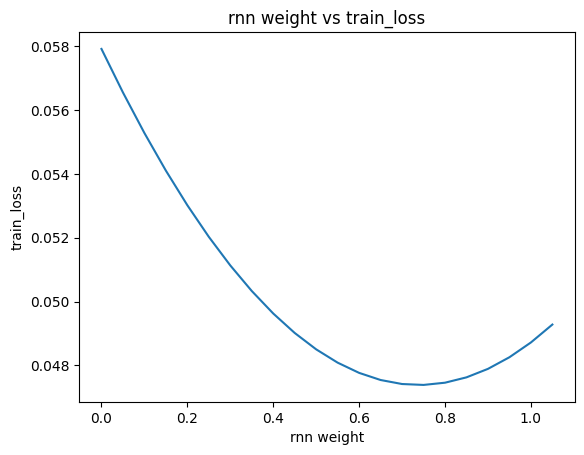

In [ ]:
min_loss = None
best_a = None
best_b = None
losses = []
a_s = []
for a in np.arange(0,1.1,0.05):
  b = 1- a
  embedded_predictions = np.zeros((len(train_y), 6))
  for pred_index in range(6):
    embedded_predictions[:, pred_index] = train_y_hat[f"y_{pred_index}"].values * a + b * train_pred_cnn[f"y_{pred_index}"].values
  # compute kl diveregence loss on targets
  train_y_targets = train_y[["y_0", "y_1", "y_2", "y_3", "y_4", "y_5"]].values

  kl_loss = F.kl_div(torch.nn.functional.log_softmax(torch.Tensor(embedded_predictions), dim=1), torch.Tensor(train_y_targets), reduction='batchmean', log_target=True)
  if min_loss is None or kl_loss.item() < min_loss:
    min_loss = kl_loss.item()
    best_a = a
    best_b = b
  losses.append(kl_loss.item())
  a_s.append(a)
print(f"best a {best_a}")
print(f"best b {best_b}")
print(f"min loss {min_loss}")
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlabel("rnn weight")
ax.set_ylabel("train_loss")
ax.set_title("rnn weight vs train_loss")
ax.plot(a_s, losses)
plt.show()

In [ ]:
## evaluate on the validation set

cnn_preds = np.zeros((len(valid_y), 6))
rnn_preds = np.zeros((len(valid_y), 6))
embedded_predictions = np.zeros((len(valid_y), 6))
for pred_index in range(6):
  cnn_preds[:, pred_index] = validation_cnn[f"y_{pred_index}"].values
  rnn_preds[:, pred_index] = valid_y_hat[f"y_{pred_index}"].values
  embedded_predictions[:, pred_index] = valid_y_hat[f"y_{pred_index}"].values * best_a + best_b * validation_cnn[f"y_{pred_index}"].values
valid_y_targets = valid_y[["y_0", "y_1", "y_2", "y_3", "y_4", "y_5"]].values
cnn_validation_loss = F.kl_div(torch.nn.functional.log_softmax(torch.Tensor(cnn_preds), dim=1), torch.Tensor(valid_y_targets), reduction='batchmean', log_target=True)
rnn_validation_loss = F.kl_div(torch.nn.functional.log_softmax(torch.Tensor(rnn_preds), dim=1), torch.Tensor(valid_y_targets), reduction='batchmean', log_target=True)
embedded_validation_loss = F.kl_div(torch.nn.functional.log_softmax(torch.Tensor(embedded_predictions), dim=1), torch.Tensor(valid_y_targets), reduction='batchmean', log_target=True)
print(f"cnn validation loss {cnn_validation_loss}")
print(f"rnn validation loss {rnn_validation_loss}")
print(f"embedded validation loss {embedded_validation_loss}")

cnn validation loss 0.0677635446190834
rnn validation loss 0.06499000638723373
embedded validation loss 0.06200966611504555
